Load Librairies

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl

Use Latex Font

In [102]:
plt.rcParams.update({
    "text.usetex": True,                # Use LaTeX for text
    "font.family": "serif",             # Use 'serif' font
    "font.serif": ["Computer Modern"],  # LaTeX default font
    "axes.labelsize": 12,               # Font size for labels
    "font.size": 12,                    # General font size
    "legend.fontsize": 12,              # Font size for legend
    "xtick.labelsize": 10,              # Font size for x-axis
    "ytick.labelsize": 10               # Font size for y-axis
})

# Data

In [103]:
def identify_drought(time_series: pd.Series,threshold:float):
    events_thresh = time_series<threshold
    raw_events = events_thresh.groupby(events_thresh.ne(events_thresh.shift()).cumsum()).cumsum()
    identified_events = raw_events[(raw_events.shift(1) < raw_events) & (raw_events.shift(-1) < raw_events)]
    identified_events.index = pd.Index([date - pd.Timedelta(identified_events.loc[date]-1, unit='h') for date in identified_events.index])
    return identified_events

In [104]:
df_combine = pd.read_csv('../Data/cf_combine_7923.csv',
                         index_col=0,
                         parse_dates=True
)

df_combine_avg = df_combine.rolling('D', min_periods=24, center=True).mean()

In [105]:
droughts_dict = {}

for column in df_combine_avg:
    raw_droughts = identify_drought(df_combine_avg[column], 0.1)
    droughts = raw_droughts[raw_droughts > 24]
    droughts_df = pd.DataFrame(droughts)
    droughts_df = droughts_df.set_axis(['Duration'], axis=1)
    droughts_dict[column] = droughts_df

# Plot

In [106]:
bar_width = 0.2
label_name = ['Atlite', 'C3S-E G', 'C3S-E N']
title_name = ['a) Wind', 'b) PV', 'c) Existing', 'd) Balanced']
color_models = ['#B03024', '#348ABD', '#988ED5']
# color_models = ['#006BA4', '#FF800E', '#ABABAB']

In [107]:
duration_ranges_hours = [24, 48, 72, 96, 120, 144, 168, 192 ,np.inf]
duration_ranges_days = [dur / 24 for dur in duration_ranges_hours]

xlabel = ['1-2','2-3','3-4','4-5','5-6','6-7', '7-8','8+', '']

In [108]:
categories = {
    'onshorewind': ['onshorewind_atlite', 'onshorewind_c3se_gridded', 'onshorewind_c3se_national'],
    'pv': ['pv_atlite', 'pv_c3se_gridded', 'pv_c3se_national'],
    'combine_2023': ['combine_atlite_2023', 'combine_c3se_gridded_2023', 'combine_c3se_national_2023'],
    'combine_2030': ['combine_atlite_2030', 'combine_c3se_gridded_2030', 'combine_c3se_national_2030']
}

In [119]:
def my_title(ax, title):
    ax.set_title(title, 
                 x=0.5, y=1,
                 pad = -18,
                #  transform=ax.transAxes,
                 fontsize=16, 
                 bbox=dict(facecolor='white', alpha=1, edgecolor='white')
    )

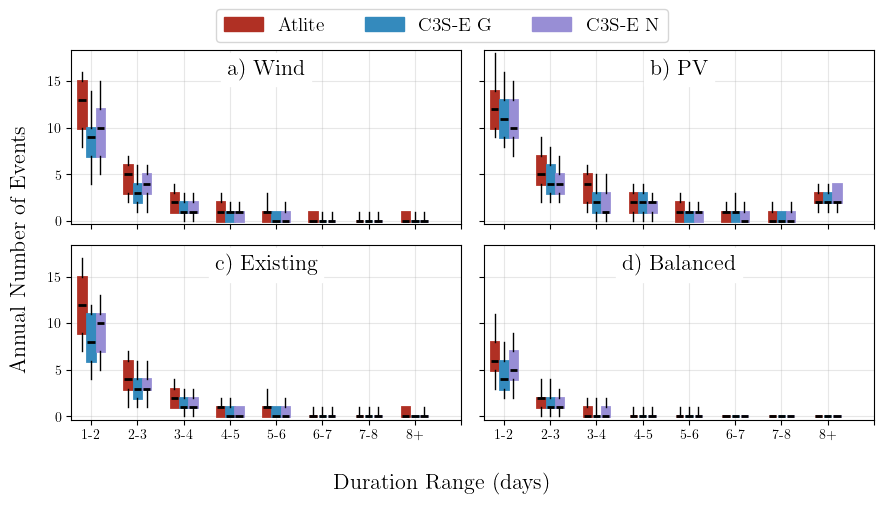

In [ ]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 5), sharex=True, sharey=True)
axs = axs.flatten()

# Loop over categories
for idx, (category, datasets_in_category) in enumerate(categories.items()):
    ax = axs[idx]


    # Initialize the position for bars
    bar_width = 0.25
    positions = np.arange(1, len(duration_ranges_days))

    # Loop over datasets in category
    for i, name in enumerate(datasets_in_category):
        df = droughts_dict[name]
        # Calculate annual number of events for each duration range
        df['DurationRange'] = pd.cut(df['Duration'], bins=duration_ranges_hours)
        df['Year'] = df.index.year
        annual_counts = df.groupby(['Year', 'DurationRange'], observed=True).size().unstack(fill_value=0)
        
        # Reindex to ensure all duration ranges are represented
        full_duration_ranges = pd.IntervalIndex.from_breaks(duration_ranges_hours, closed='right')
        annual_counts = annual_counts.reindex(columns=full_duration_ranges, fill_value=0)

        # Extract the data for the boxplot
        boxplot_data = [annual_counts[duration].values for duration in full_duration_ranges]

        # Plot boxplot
        boxprop = dict(facecolor=color_models[i], color=color_models[i], linewidth=2)       # Parameters for the box
        medianprop = dict(color='black', linewidth=2)                                       # Parameters for median line
        flierprop = dict(markeredgecolor=color_models[i], marker='o', ms=1)                       # Parameters for fliers 
        bplot = ax.boxplot(boxplot_data, positions=positions + i * 0.2 - 0.2, widths=0.16,  # Draw
                            patch_artist = True,                                            # Fills boxplot         
                            boxprops = boxprop,                                             # Parameters for the box
                            medianprops = medianprop,                                       # Parameters for median line
                            whis = (5,95),
                            showfliers = False, flierprops = flierprop,                      # Show the fliers
                            manage_ticks = False,                                           # Set the xlabels manually
                            notch = False,                                                  # Curve boxplot
                            capwidths = 0,
                            # meanline = False, showmeans = True,                             # Show Mean as line or points
                            zorder=2
        )                                                       


    my_title(ax, title_name[idx])
    ax.grid(True, alpha=0.3, zorder=0)
    ax.margins(0.02)
    # x-axis
    ax.set_xticks(np.arange(1, len(duration_ranges_days)+1))
    ax.set_xticklabels(xlabel)

# Legend 
handles = [mpatches.Patch(color=color_models[i], label=label_name[i]) for i in range(len(color_models))]
fig.legend(handles = handles, 
           fontsize = 14, 
           loc = 'upper center',
           alignment = 'center',
           ncols=3)

fig.supxlabel('Duration Range (days)', fontsize=16)
fig.supylabel('Annual Number of Events', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.savefig('../Figures/droughts_number_events.png', dpi=300)

In [111]:
cm = 1/2.54

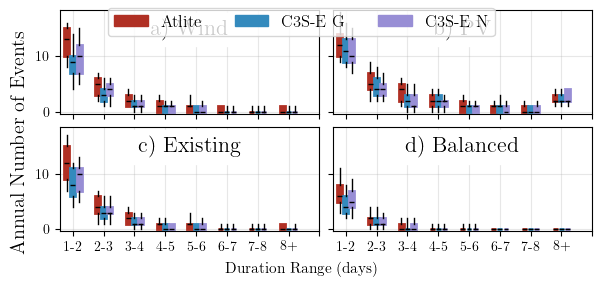

In [ ]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15*cm, 7*cm), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()

# Loop over categories
for idx, (category, datasets_in_category) in enumerate(categories.items()):
    ax = axs[idx]


    # Initialize the position for bars
    bar_width = 0.25
    positions = np.arange(1, len(duration_ranges_days))

    # Loop over datasets in category
    for i, name in enumerate(datasets_in_category):
        df = droughts_dict[name]
        # Calculate annual number of events for each duration range
        df['DurationRange'] = pd.cut(df['Duration'], bins=duration_ranges_hours)
        df['Year'] = df.index.year
        annual_counts = df.groupby(['Year', 'DurationRange'], observed=True).size().unstack(fill_value=0)
        
        # Reindex to ensure all duration ranges are represented
        full_duration_ranges = pd.IntervalIndex.from_breaks(duration_ranges_hours, closed='right')
        annual_counts = annual_counts.reindex(columns=full_duration_ranges, fill_value=0)

        # Extract the data for the boxplot
        boxplot_data = [annual_counts[duration].values for duration in full_duration_ranges]

        # Plot boxplot
        boxprop = dict(facecolor=color_models[i], color=color_models[i], linewidth=2)       # Parameters for the box
        medianprop = dict(color='black', linewidth=1)                                       # Parameters for median line
        flierprop = dict(markeredgecolor=color_models[i], marker='o', ms=1)                       # Parameters for fliers 
        bplot = ax.boxplot(boxplot_data, positions=positions + i * 0.2 - 0.2, widths=0.16,  # Draw
                            patch_artist = True,                                            # Fills boxplot         
                            boxprops = boxprop,                                             # Parameters for the box
                            medianprops = medianprop,                                       # Parameters for median line
                            whis = (5,95),
                            showfliers = False, flierprops = flierprop,                      # Show the fliers
                            manage_ticks = False,                                           # Set the xlabels manually
                            notch = False,                                                  # Curve boxplot
                            capwidths = 0,
                            # meanline = False, showmeans = True,                             # Show Mean as line or points
                            zorder=2
        )                                                       


    my_title(ax, title_name[idx])
    ax.grid(True, alpha=0.3, zorder=0)
    ax.margins(0.02)

    # x-axis
    ax.set_xticks(np.arange(1, len(duration_ranges_days)+1))
    ax.set_xticklabels(xlabel)

# # Legend 
handles = [mpatches.Patch(color=color_models[i], label=label_name[i]) for i in range(len(color_models))]
fig.legend(handles=handles, loc = 'upper center', alignment = 'center', ncols=3)

fig.supxlabel('Duration Range (days)', fontsize=11)
fig.supylabel('Annual Number of Events')
# fig.tight_layout()
# fig.subplots_adjust(top=0.9)

fig.savefig('../Figures/droughts_number_events2.png', dpi=300)